# Определение перспективного тарифа для телеком. компании

### Цель исследования:

На основе исторических данных определить наилучший (с точки зрения бизнеса) тариф телеком-компании.

Для этого нам потребуется провести предобработку данных, исследовательский анализ данных, а также сформулировать рабочие гипотезы и выводы.

Подключим необходимые библиотеки, откроем исходные файлы с данными, оценим фронт работ.

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import math
from scipy import stats as st

# добавил это условие для того, чтобы скрыть предупреждения, связанные с копированием датафрейма.
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
calls = pd.read_csv("/datasets/calls.csv")
internet = pd.read_csv("/datasets/internet.csv")
messages = pd.read_csv("/datasets/messages.csv")
tariffs = pd.read_csv("/datasets/tariffs.csv")
users = pd.read_csv("/datasets/users.csv")

## 1. Предобработка данных

### Тарифы
Изучим каждый из датафреймов по отдельности. Начнем с файла, содержащего информацию по тарифам.

In [3]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Всего 2 строки данных - ведь анализируемых тарифов у нас всего 2. Смотреть особо не на что. Данные совпадают с заявленными в описании проекта, столбцы поименованны корректно, тип данных выбран также верно - предобрабатывать нечего.

Переходим к следующему по логике датасету - пользователи.

### Пользователи

In [4]:
users.info()
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Датасет представлен столбцами:
- id пользователя
- возраст
- дата отключения
- город
- Имя
- Фамилия
- дата регистрации
- тариф

Во всех столбцах, за исключением "даты отключения" нет пропусков. Пропуски свидетельствуют о факте "подключенности" тарифа на момент сбора данных. Заполним пропуски индикаторным значением - например, 1.1.2000 года - достаточно отдаленная дата для получения во всех возможных случаях отрицательно длительности "существования" тарифа у конкретного пользователя.

Кроме того, необходимо будет заменить тип данных в столбцах "churn_date" и "reg_date" на datetime.

In [5]:
users['churn_date'] = users['churn_date'].fillna("2000-01-01")
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users.info()
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2000-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2000-01-01,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2000-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2000-01-01,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2000-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,2000-01-01,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,2000-01-01,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,2000-01-01,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,2000-01-01,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,2000-01-01,Пермь,Василиса,Блинова,2018-03-22,smart


Пропуски удалили, тип данных поменяли, переходим к следующим датасетам.

### Звонки

In [6]:
calls.info()
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Здесь столбцов 4:
- id принадлежности к пользователю
- дата звонка
- длительность
- id пользователя

В столбце "длительность" присутствуют нулевые значения. Вероятно, это звонки-"недозвоны". 
Заменим тип данных в столбце "call_date"  на datetime.

In [7]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Поскольку пропусков в таблице не видно, переходим к следующему датасету.

### Интернет

In [8]:
internet.info()
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


По аналоги с предшествующими датасетами, заменим тип данных в столбце "дата сеанса" на datetime.

In [9]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Как и в таблице со звонками, 2 пересекающихся столбца - id принадлежности к пользователю и id пользователя.
2 столбца "новых":
- дата интернет-сессии
- объем трафика

Пропусков также нет - тип данных мы заменили, переходим к следующему датасету.

### Сообщения

In [10]:
messages.info()
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Вновь 2 "стандартных" столбца. "Уникальный" столбец данного датасета:
- дата пересылки сообщения

Пропусков нет, столбцов всего 3. Традиционно меняем тип данных в столбце "дата сообщения" для дальнейшей работы.

In [11]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


# Выводы

Во всех из имеющихся датасетов (кроме тарифов) есть один смежный столбец - user_id. По нему, в дальнейшем будем эти датасеты клеить и разбираться, кто из пользователей сколько потратил денег на звонки, смс, интернет и какой из тарифов выгодней. Сейчас необходимо разобраться в нулевых значениях в датасетах со звонками и интернетом, т.к. они будут препятствовать получению корректных результатов в процессе анализа данных.

## 2. Подготовка данных

В предшествующем разделе были выделены основные "проблемы", обнаруженные при обработке данных - нулевые значения. Откроем датасет, посчитаем их и разработаем возможный путь решения.

### Звонки

In [12]:
calls[calls['duration'] == 0]['duration'].count()

39613

Из 202 тысяч значений почти 40 тысяч - пустые значения. Что можем с этим сделать? Обратимся к информации о тарифах. Имеют ли для нас данные значения хоть какой-то смысл? 

In [13]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Поскольку в каждом из тарифов есть 500(3000) минут бесплатных звонков в месяц + последующая тарификация за каждую минуту (с посекундной тарификацией), нам нет совершенно никакого дела до "недозвонов". Удалим строчки, "ресетнем" индексы.

In [14]:
calls_no_zero_dur = calls[calls['duration'] != 0].reset_index(drop = True)
calls_no_zero_dur.head(10)

,id,call_date,duration,user_id
0,1000_2,2018-06-11,2.85,1000
1,1000_3,2018-09-21,13.80,1000
2,1000_4,2018-12-15,5.18,1000
3,1000_7,2018-08-22,18.31,1000
4,1000_8,2018-09-15,18.44,1000
5,1000_10,2018-08-22,5.03,1000
6,1000_11,2018-05-28,18.82,1000
7,1000_12,2018-07-05,2.02,1000
8,1000_13,2018-09-29,7.15,1000
9,1000_14,2018-12-11,9.13,1000


В колонке id видно, как я "поломал" последовательность нумерации звонков для каждого клиента. Однако, я не до конца на данный момент понимаю необходимость данного столбца в рамках нашего проекта вообще, потому оставим его в покое и посмотрим, нет ли среди анализируемых значений в данной таблице каких-либо ещё "странных" значений.

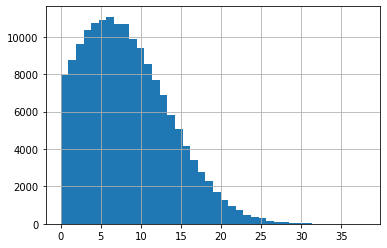

In [15]:
calls_no_zero_dur['duration'].hist(bins = 40)

Выглядит как нормальное распределение, скошенное вправо. Посмотрим на статистические показатели.

In [16]:
calls_no_zero_dur['duration'].describe()

count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64

При средней длительности разговора равной 8.4 минуты, медианной 7.7 минут и стандратном отклонении 5.35 мин. длительность разговора в 38 минут (максимальная зафиксированная в пределах рассматрваемого датасета) выглядит как выброс (8.4 + 5.35 * 3 = 24,45 минут - верхний предел статистической значимости рассматриваемых значений. Всё что выше - ни что иное, как выброс. Придержим эти выводы и перейдем к следующему датасету.

### Интернет

In [17]:
internet[internet['mb_used'] == 0]['mb_used'].count()

19598

"Пустые" 19.6 тысяч значений из 150 тысяч. По аналогии с тарифами, сам факт "входа" в сеть без расходования трафика нас не интересует - вычищаем и смотрим, на то, что получится.

In [18]:
internet_no_zero_mb = internet[internet['mb_used'] != 0].reset_index(drop = True)
internet_no_zero_mb.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


Осталось около 130 тысяч значений, но, что важно, все "наполненны". Вопрос, конечно, чем. Давайте это и выясним.

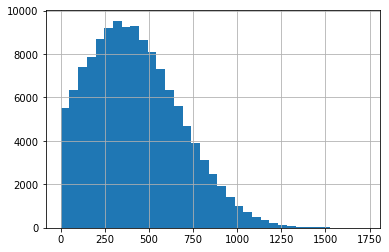

In [19]:
internet_no_zero_mb['mb_used'].hist(bins = 35)

Аналогично, датасет скошен вправо. Выведем статистические показатели на экран.

In [20]:
internet_no_zero_mb['mb_used'].describe()

count    129798.000000
mean        426.087210
std         255.596447
min           0.030000
25%         227.460000
50%         400.540000
75%         592.947500
max        1724.830000
Name: mb_used, dtype: float64

Верхняя граница нормального распределения - 1193 Мб (среднее + 3 стандартных отклонения), всё выше - выброс. Пока оставляем таблицу как есть и двигаемся дальше.

### Пользователи

Аккумулируем данные по пользователям в отдельную таблицу - сводимся частями из разных датасетов и собираем всё в один - новый, укрупненный. Но перед этим, выполним важный процесс - округлим все значения длительности звонков и интернета (каждого сеанса) вверх до целого значения минут и мегабайт, т.к. "мегалайн" всегда округляет их вверх. 0.1 Мб = 1 Мб. 10 раз по 0.1 Мб != 1 Мб, а = 10 Мб (!!!!!) Это важный пункт, про него нельзя забывать.

In [21]:
def up_round(duration):
    return math.ceil(duration)

calls_no_zero_dur['duration'] = calls_no_zero_dur['duration'].apply(up_round)
calls_no_zero_dur.head(10)

,id,call_date,duration,user_id
0,1000_2,2018-06-11,3,1000
1,1000_3,2018-09-21,14,1000
2,1000_4,2018-12-15,6,1000
3,1000_7,2018-08-22,19,1000
4,1000_8,2018-09-15,19,1000
5,1000_10,2018-08-22,6,1000
6,1000_11,2018-05-28,19,1000
7,1000_12,2018-07-05,3,1000
8,1000_13,2018-09-29,8,1000
9,1000_14,2018-12-11,10,1000


Значения для звонков округлили вверх, переходим к значениям для интернета.

In [22]:
internet_no_zero_mb['mb_used'] = internet_no_zero_mb['mb_used'].apply(up_round)
internet_no_zero_mb.head(10)

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000
5,1000_5,400,2018-10-02,1000
6,1000_6,541,2018-09-07,1000
7,1000_7,416,2018-07-11,1000
8,1000_8,506,2018-10-08,1000
9,1000_9,346,2018-09-03,1000


Также для сбора информации по месяцам нам потребуется добавить дополнительный столбец "месяц" (без года, т.к. данные у нас - исключительно за 2018 год). Напишем функцию и применим её ко всем 3 "исходным" датасетам.

In [23]:
def month_apply(data):
    return data.month

calls_no_zero_dur['month'] = calls_no_zero_dur['call_date'].apply(month_apply)
internet_no_zero_mb['month'] = internet_no_zero_mb['session_date'].apply(month_apply)
messages['month'] = messages['message_date'].apply(month_apply)

Итоговыф таблицы будут проиндексированы по 2 значениями - по user_id и месяцу. Таблиц по звонкам будет 2 - 1 по количеству звонков, другая по длительности разговоров.

In [24]:
users_calls_dur = calls_no_zero_dur.pivot_table(index = ('user_id', 'month'),
                                            values = 'duration', aggfunc = 'sum', fill_value = 0)

users_calls_count = calls_no_zero_dur.pivot_table(index = ('user_id', 'month'),
                                            values = 'duration', aggfunc = 'count', fill_value = 0)
users_calls_dur.columns = ["calls_duration"]
users_calls_dur.head(10)

calls_duration
user_id month                
1000    5                 159
        6                 172
        7                 340
        8                 408
        9                 466
        10                350
        11                338
        12                333
1001    11                430
        12                414

Заменим название столбца в сводной таблице с количеством звонков на корректное.

In [25]:
users_calls_count.columns = ["calls_number"]
users_calls_count.head(10)

calls_number
user_id month              
1000    5                17
        6                28
        7                41
        8                42
        9                46
        10               44
        11               37
        12               38
1001    11               45
        12               47

Теперь интернет. Логика сбора и обработки та же.

In [26]:
users_internet = internet_no_zero_mb.pivot_table(index = ('user_id', 'month'), 
                                                 values = 'mb_used', aggfunc = 'sum', fill_value = 0)
users_internet.head(10)

mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581
        10       14717
        11       14768
        12        9827
1001    11       18452
        12       14053

А теперь сообщения.

In [27]:
users_messages = messages.pivot_table(index = ('user_id', 'month'), 
                                      values = 'message_date', aggfunc = 'count', fill_value = 0)
users_messages.columns = ["messages_number"]
users_messages.head(10)

messages_number
user_id month                 
1000    5                   22
        6                   60
        7                   75
        8                   81
        9                   57
        10                  73
        11                  58
        12                  70
1002    6                    4
        7                   11

Для удобства дальнейшей работы, расчетов и т.п., объединим полученные таблицы со значениями величин использования различных услуг в одну. Воспользуемся методом merge, в качестве критерия используем 'outer', т.к. часть абонентов не пользовалась одними услугами (например, сообщениями), а другими - пользовалась (например, интернетом). Нам же необходимо максимально охватить весь имеющийся контингент пользователей.

In [28]:
def merge_func(data1, data2):
    data3 = data1.merge(data2, how = "outer", on = ("user_id", "month")).fillna(0).astype('int')
    return data3

users_total = merge_func(users_calls_dur, users_calls_count)
users_total = merge_func(users_total, users_internet)
users_total = merge_func(users_total, users_messages)
users_total.head(10)

calls_duration  calls_number  mb_used  messages_number
user_id month                                                        
1000    5                 159            17     2256               22
        6                 172            28    23257               60
        7                 340            41    14016               75
        8                 408            42    14070               81
        9                 466            46    14581               57
        10                350            44    14717               73
        11                338            37    14768               58
        12                333            38     9827               70
1001    11                430            45    18452                0
        12                414            47    14053                0

Для упрощения работы с данными, разделим полученную таблицу на 2 - в зависимости от тарифа. Для этого из таблицы users достанем 2 списка с номерами id для соответствующих тарифов.

In [29]:
users_id_smart = users[users['tariff'] == "smart"]['user_id']
users_id_ultra = users[users['tariff'] == "ultra"]['user_id']

Получили 2 списка принадлежности id к тому или иному тарифу. Теперь, на его основании можем провести заявленное "разделение".

In [30]:
users_total_smart = users_total.query('user_id in @users_id_smart')
users_total_ultra = users_total.query('user_id in @users_id_ultra')

users_total_smart.head(10)

calls_duration  calls_number  mb_used  messages_number
user_id month                                                        
1001    11                430            45    18452                0
        12                414            47    14053                0
1002    6                 117            14    10871                4
        7                 214            21    17601               11
        8                 289            37    20347               13
        9                 206            25    16712                4
        10                212            24    13905               10
        11                243            25    18610               16
        12                236            27    18137               12
1005    1                  95            11     2730                7

В первом списке осталось 2229 строк из 3214 в исходном users_total. По логике, если у нас нет потерь, во втором должно остаться 985 строк. Удостоверимся в этом.

In [31]:
users_total_ultra['calls_duration'].count()

985

Все верно! Таким образом, у нас есть 2 отдельных дата фрейма, в которых собраны все необходимые нам данные для расчета ежемесячной выручки для каждого клиента в зависимости от тарифа. 

Столбец с выручкой получить относительно несложно. Однако, сам по себе, он мало информативен в том смысле, что не ясно, за какие услуги люди чаще всего в течение месяца платят сверх абонентской платы (за дополнительный трафик, звонки или, может, сообщения?). Потому, я решил расширить перечень представляемых и рассчитываемых данных следующим образом.

В итоговую таблицу добавим столбцы с "перерасходом" той или иной услуги сверх тарифных лимитов, а также сумму, которую человек платит дополнительно за их использование + итоговое значение выручки.

In [32]:
def excess_calc(tariff_value, limit):
    if tariff_value > limit:
        excess = tariff_value - limit
        return excess
    else:
        return 0
        

users_total_smart['min_excess'] = users_total_smart['calls_duration'].apply(excess_calc, args=[500])
users_total_smart

calls_duration  calls_number  mb_used  messages_number  \
user_id month                                                           
1001    11                430            45    18452                0   
        12                414            47    14053                0   
1002    6                 117            14    10871                4   
        7                 214            21    17601               11   
        8                 289            37    20347               13   
...                       ...           ...      ...              ...   
1489    8                   0             0    11066               17   
        9                   0             0    17232               32   
        10                  0             0    19588               21   
        11                  0             0    17516               20   
        12                  0             0    17341               35   

               min_excess  
user_id month              
1001    11              0  
        12              0  
1002    6               0  
        7               0  
        8               0  
...                   ...  
1489    8               0  
        9               0  
        10              0  
        11              0  
        12              0  

[2229 rows x 5 columns]

Проделаем аналогичную работу для двух других параметров и посчитаем итоговое значение выручки, просуммировав абонентскую плату и дополнительную плату за пользование доп. пакетами услуг.

In [33]:
users_total_smart['mb_excess'] = users_total_smart['mb_used'].apply(
    excess_calc, args=[15360])
users_total_smart['mes_excess'] = users_total_smart['messages_number'].apply(
    excess_calc, args=[50])

def revenue_calc(excess, amount, cost):
    revenue = math.ceil(excess / amount) * cost
    return revenue

users_total_smart['min_exc_rev'] = users_total_smart['min_excess'].apply(revenue_calc, args = [1, 3])
users_total_smart['mb_exc_rev'] = users_total_smart['mb_excess'].apply(revenue_calc, args = [1024, 200])
users_total_smart['mes_exc_rev'] = users_total_smart['mes_excess'].apply(revenue_calc, args = [1, 3])

users_total_smart['total_revenue'] = (550 + users_total_smart['min_exc_rev'] +
                                           users_total_smart['mb_exc_rev'] + 
                                          users_total_smart['mes_exc_rev'])

users_total_smart

calls_duration  calls_number  mb_used  messages_number  \
user_id month                                                           
1001    11                430            45    18452                0   
        12                414            47    14053                0   
1002    6                 117            14    10871                4   
        7                 214            21    17601               11   
        8                 289            37    20347               13   
...                       ...           ...      ...              ...   
1489    8                   0             0    11066               17   
        9                   0             0    17232               32   
        10                  0             0    19588               21   
        11                  0             0    17516               20   
        12                  0             0    17341               35   

               min_excess  mb_excess  mes_excess  min_exc_rev  mb_exc_rev  \
user_id month                                                               
1001    11              0       3092           0            0         800   
        12              0          0           0            0           0   
1002    6               0          0           0            0           0   
        7               0       2241           0            0         600   
        8               0       4987           0            0        1000   
...                   ...        ...         ...          ...         ...   
1489    8               0          0           0            0           0   
        9               0       1872           0            0         400   
        10              0       4228           0            0        1000   
        11              0       2156           0            0         600   
        12              0       1981           0            0         400   

               mes_exc_rev  total_revenue  
user_id month                              
1001    11               0           1350  
        12               0            550  
1002    6                0            550  
        7                0           1150  
        8                0           1550  
...                    ...            ...  
1489    8                0            550  
        9                0            950  
        10               0           1550  
        11               0           1150  
        12               0            950  

[2229 rows x 11 columns]

Теперь тоже самое - для датасета с данными по тарифу ультра. Помним, что параметры в используемых функциях будут отличными от используемых вместе с тарифом Smart.

In [34]:
users_total_ultra['min_excess'] = users_total_ultra['calls_duration'].apply(
    excess_calc, args=[3000])
users_total_ultra['mb_excess'] = users_total_ultra['mb_used'].apply(
    excess_calc, args=[30720])
users_total_ultra['mes_excess'] = users_total_ultra['messages_number'].apply(
    excess_calc, args=[1000])

users_total_ultra['min_exc_rev'] = users_total_ultra['min_excess'].apply(revenue_calc, args = [1, 1])
users_total_ultra['mb_exc_rev'] = users_total_ultra['mb_excess'].apply(revenue_calc, args = [1024, 150])
users_total_ultra['mes_exc_rev'] = users_total_ultra['mes_excess'].apply(revenue_calc, args = [1, 1])

users_total_ultra['total_revenue'] = (1950 + users_total_ultra['min_exc_rev'] +
                                           users_total_ultra['mb_exc_rev'] + 
                                          users_total_ultra['mes_exc_rev'])

users_total_ultra

calls_duration  calls_number  mb_used  messages_number  \
user_id month                                                           
1000    5                 159            17     2256               22   
        6                 172            28    23257               60   
        7                 340            41    14016               75   
        8                 408            42    14070               81   
        9                 466            46    14581               57   
...                       ...           ...      ...              ...   
1473    9                   0             0    17307               19   
        10                  0             0    13703               20   
        11                  0             0    21692               14   
        12                  0             0    18432               20   
1476    4                   0             0      531                0   

               min_excess  mb_excess  mes_excess  min_exc_rev  mb_exc_rev  \
user_id month                                                               
1000    5               0          0           0            0           0   
        6               0          0           0            0           0   
        7               0          0           0            0           0   
        8               0          0           0            0           0   
        9               0          0           0            0           0   
...                   ...        ...         ...          ...         ...   
1473    9               0          0           0            0           0   
        10              0          0           0            0           0   
        11              0          0           0            0           0   
        12              0          0           0            0           0   
1476    4               0          0           0            0           0   

               mes_exc_rev  total_revenue  
user_id month                              
1000    5                0           1950  
        6                0           1950  
        7                0           1950  
        8                0           1950  
        9                0           1950  
...                    ...            ...  
1473    9                0           1950  
        10               0           1950  
        11               0           1950  
        12               0           1950  
1476    4                0           1950  

[985 rows x 11 columns]

## 3. Анализ полученных данных

В рамках проекта мне необходимо описать поведение клиентов оператора, определить основные статистические показатели пользователей каждого из тарифов в месяц - среднего, дисперсии и стандартного отклонения. Начну с определения статистических показателей для пользователей тарифа smart. 

## Тариф "Smart"
### Длительность разговоров

In [35]:
users_total_smart['calls_duration'].describe()

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: calls_duration, dtype: float64

Среднее + 3 стандартных отклонения явно находятся ниже максимального значения. Плюс в выборке имеются нули - нас эти значения не интересуют. Нули удалим, а на значения выше верхнего уровня посмотрим на гистограмме.

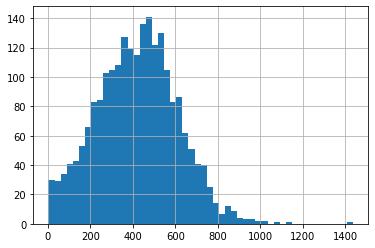

In [36]:
users_smart_no_zero_dur = users_total_smart[users_total_smart['calls_duration'] != 0]
users_smart_no_zero_dur['calls_duration'].hist(bins = 50)

Значения свыше 1000 минут в месяц (для тарифа, в котором идёт всего 500 "бесплатных" минут) практически не встречаются. Сверху наше распределение ограничим значением среднего арифметического + 3 стандартных отклонения. Обрежем имеющийся датасет по этому значению и продолжим анализ.

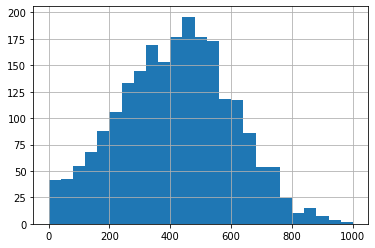

In [37]:
top_smart_duration_limit = (users_smart_no_zero_dur['calls_duration'].mean() +
                      3 * users_smart_no_zero_dur['calls_duration'].std())

users_smart_clean_dur = users_smart_no_zero_dur[users_smart_no_zero_dur['calls_duration'] <=
                                                top_smart_duration_limit]

users_smart_clean_dur['calls_duration'].hist(bins = 25, range = (0, 1000))

На гистограмме можно увидеть небольшой перекос полученных значений в левую сторону. Вероятно, это связано с наличием т.н. "неполных месяцев" - месяцев, когда пользователь только начинает пользоваться тарифом - например, подключился 23 числа, пользовался тарифом 7 дней, а мы, в дальнейшем анализе используем полученные данные "вровень" с данными, полученными за целый месяц. На мой взгляд, здесь возможны 2 различных варианта обработки таких "неполных" значений:
1. Введение некоторого "приведенного" параметра - например, "условного месяца", который будет представлять собой аппроксимированное значение, определенное для месяца на основании его части - говорили 7 дней, нужна информация для 30 дней. Полученное значение делим на 7, умножаем на 30 и получаем искомое. Однако, данный подход не совсем корректен в связи с высоким риском возникновения выбросов вследствие аппроксимации. Для использования данного подхода, в первую очередь, необходимо будет построить "равномерность" распределения звонков в течение месяца - если люди разговаривают "примерно" одинаково в течение месяца - по 5-10-20 минут в день (+-), то такой подход, действительно имеет смысл;
2. Устранение из имеющегося датафрейма значений, соответствующих неполному месяцу. Для этого из исходного файла users извлечем месяц подключения для каждого из пользователей (при условии, что подключение было в 2018 году) и уберем из выборки значения для этих "первых, неполных" месяцев. Основной риск, который я вижу в данном подходе заключается в существенном уменьшении объема анализируемых данных. Учитывая, что пользователей всего 500, а строчек со значениями 3214, высока вероятность (ведь 3214 / 500 = 6.4 мес), что мы выбросим из выборки почти 1/6 часть всех значений. Кроме того, не стоит забывать про наличие "отключившихся". Их "последние месяцы" также "заслуживают" выбрасывания из списка. Но это также чревато потерей данных. С другой стороны, эти данные явно "corrupted" - искажены. 

Пока подвешу данный момент как гипотезу возможной доработки и продолжу работать с имеющимся данными.

In [38]:
# здесь, при необходимости, я напишу код расчистки данных

#users_smart_clean = users_smart_clean.drop([(1002,6)], inplace = True)

Посмотрим на статистические показатели обработанной выборки и опишем её.

In [39]:
users_smart_clean_dur['calls_duration'].describe()

count    2214.000000
mean      417.294490
std       185.208838
min         2.000000
25%       285.000000
50%       422.000000
75%       544.000000
max       965.000000
Name: calls_duration, dtype: float64

Выброшенных значений (0 и сверхбольших) всего 15 шт. Стало быть, эти значения действительно можно рассматривать как выбросы - "уникальные" случаи сверхобщения или, напротив, НЕобщения.

В среднем, пользователи тарифа Smart разговаривают по телефону 417 минут в месяц, т.е. выговаривают почти 84% от включенного в тариф лимита на разговоры (500 минут). При этом, важно понимать, что почти 30% пользователей за этот лимит переваливают - т.е. почти 30% пользователей тарифа smart "переплачивают" за пользование мобильной связью. Тем не менее, переходить на тариф ultra им явно не с руки - в 100% случаев они бы не смогли выбрать весь имеющийся лимит по звонкам даже на треть (от 3000 мин/мес). 

### Количество сообщений

In [40]:
users_total_smart['messages_number'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_number, dtype: float64

Максимальное число смс, отправленных пользователем, составляет 143 шт. Построим на основании полученных данных гистограмму.

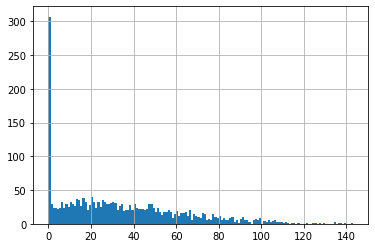

In [41]:
users_total_smart['messages_number'].hist(bins = 143, range = (0, 143))

Безумное количество месяцев без смс сообщений - 300+ из 2229. Уберем их и посмотрим на полученное распределение.

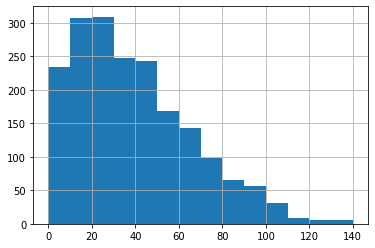

In [42]:
users_smart_no_zero_mes = users_total_smart[users_total_smart['messages_number'] != 0]
users_smart_no_zero_mes['messages_number'].hist(bins = 14, range = (0, 140))

Распределение выглядит "нормально" с большим хвостом справа. Посмотрим на статистические показатели и обрежем полученный датафрейм по верхнему значению. 

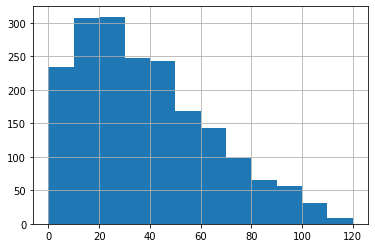

In [43]:
top_smart_messages_limit = (users_smart_no_zero_mes['messages_number'].mean() +
                      3 * users_smart_no_zero_mes['messages_number'].std())
users_smart_clean_mes = (users_smart_no_zero_mes[users_smart_no_zero_mes['messages_number'] <= 
                                                   top_smart_messages_limit])
users_smart_clean_mes['messages_number'].hist(bins = 12, range = (0,120))

Вновь посмотрим на статистические показатели выборки и сформулируем выводы.

In [44]:
users_smart_clean_mes['messages_number'].describe()

count    1911.000000
mean       38.181057
std        25.910674
min         1.000000
25%        17.000000
50%        33.000000
75%        55.000000
max       117.000000
Name: messages_number, dtype: float64

Здесь выброшенных значений намного больше - 311 штук. Вспоминая исходную гистограмму, можно утверждать, что это практически полностью нулевые значения. О чем это говорит? Люди предпочитают общаться ИНАЧЕ - не через смс. И если в случае звонков можно утверждать, что люди "не специально" не говорили по телефону (короткий месяц и т.п.), то в данном случае, среди выборки НАВЕРНЯКА найдутся пользователи, в которые люди говорили по телефону и НЕ ОТПРАВЛЯЛИ смс. Данный вид связи постепенно отмирает, потому такая ситуация вполне очевидна и логична. Тем не менее, это только гипотетический будущий потенциал ситуации, а нас интересует здесь-и-сейчас. 

В среднем, в месяц пользователи отправляют 38 сообщений. Однако, учитывая стандартное отклонение = 26 и тот факт, что в 75% случаев пользователи не отправляют более 55 смс в месяц (что даже меньше чем МЮ + 1 * СИГМА), можно сделать вывод, что пользователи преимущественно предпочитают иные способы передачи информации - интернет, звонки и т.д. Это также можно наблюдать на гистограмме распределения значений - несмотря на длинный хвост справа от среднего значения, она очень сильно скошена ВЛЕВО (за счёт огромного числа "малых" значений). Тем не менее, как и в случае со звонками, почти в 30% случаев пользователи платят за сообщения сверх абонентской платы.

### Объем интернет-трафика

С интернет-трафиком поступаем аналогично звонкам и сообщениям.

In [45]:
users_total_smart['mb_used'].describe()

count     2229.000000
mean     16229.188425
std       5877.576978
min          0.000000
25%      12658.000000
50%      16531.000000
75%      20068.000000
max      38610.000000
Name: mb_used, dtype: float64

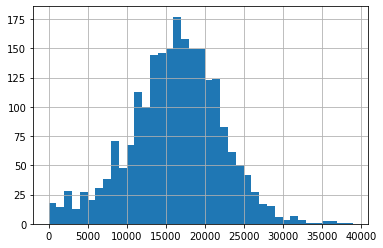

In [46]:
users_total_smart['mb_used'].hist(bins = 39, range = (0, 39000))

Типичное нормальное распределение. Удалим нулевые значения и посмотрим на происходящее ещё раз.
Также найдем граничные статистические значения сверху и снизу.

In [47]:
users_smart_no_zero_mb = (users_total_smart
                          [users_total_smart['mb_used'] != 0])

down_smart_mb_limit = (users_smart_no_zero_mb['mb_used'].mean() -
            3 * users_smart_no_zero_mb['mb_used'].std())
top_smart_mb_limit = (users_smart_no_zero_mb['mb_used'].mean() + 
           3 * users_smart_no_zero_mb['mb_used'].std())

print("Нижняя граница нормального распределения:", down_smart_mb_limit)
print("Верхняя граница нормального распределения:", top_smart_mb_limit)


Нижняя граница нормального распределения: -1336.3624650687343
Верхняя граница нормального распределения: 33823.889182625986


Поскольку значение нижней границы < 0, вместо неё примем 0. Сверху - 33 823 мб. 
Все остальное выбросим.

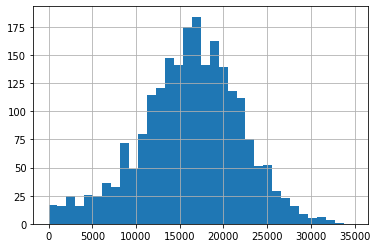

In [48]:
users_smart_clean_mb = (users_smart_no_zero_mb
                        [users_smart_no_zero_mb['mb_used'] <= top_smart_mb_limit])
users_smart_clean_mb['mb_used'].hist(bins = 34, range = (0, 34*1024))

In [49]:
users_smart_clean_mb['mb_used'].describe()

count     2219.000000
mean     16172.567373
std       5748.502726
min        202.000000
25%      12649.500000
50%      16496.000000
75%      20035.000000
max      32781.000000
Name: mb_used, dtype: float64

Выброшено всего 10 значений. И это, наверняка, тоже "выбросы", причем, преимущественно, сверхтяжелые - свыше 34 Гб.
Люди пользуются интернетом очень активно - это подтверждается средним значением трафика (16.2 тыс. Мб) и стандартного отклонения (5.75 тыс. Мб). 

В среднем люди, пользующиеся тарифом smart, выбирают весь пакет трафика (15 Гб) и немного добирают сверх - 1-2 гб, что, в отсутствие превышений по звонкам и сообщениям соответствует плате в 750-950 рублей, что в 1.4-1.8 раз превышает абонентскую плату. С вероятностью более 50% человек на тарифе smart, приобретает как минимум 1 дополнительный пакет трафика. А это уже рост выручки от данной категории пользователей почти на 40%. 

При этом (1950 - 550 = 1400 / 200 = 7, 15 + 7 = 22), для пользователей, "съедающих" более 22 Гб трафика, можно рекомендовать перейти на тариф Ultra, т.к. они тратят аналогичную сумму за счет (7+)кратной докупки пакетов трафика. А зачем это делать, если можно за те же деньги (1950 рублей/мес) получить 30 Гб и вагон минут и т.п. в придачу? Вопрос риторический.

## Тариф "Ultra"
Логика анализа значений, для тарифа Smart ничем не отличается от тарифа Ultra. Единственное, в этом же разделе мы проведем сравнение тарифов, что называется "не отходя от кассы".
### Длительность разговоров

In [50]:
users_total_ultra['calls_duration'].describe()

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: calls_duration, dtype: float64

Убираем нули и двигаемся дальше.

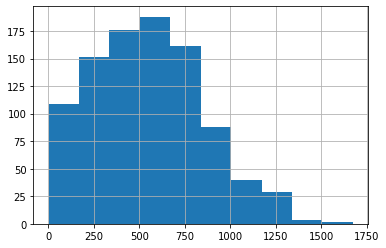

In [51]:
users_ultra_no_zero_dur = (users_total_ultra
                           [users_total_ultra['calls_duration'] != 0])
users_ultra_no_zero_dur['calls_duration'].hist()

Обрезаем хвост полученным данным (по верхней границе) и строим совмещенные гистограммы.

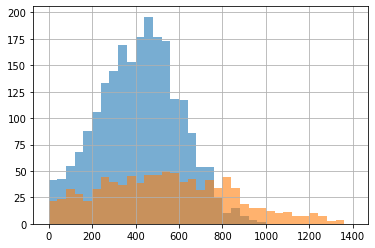

In [52]:
top_ultra_duration_limit = (users_ultra_no_zero_dur['calls_duration'].mean() + 
                            3 * users_ultra_no_zero_dur['calls_duration'].std())
users_ultra_clean_dur = users_ultra_no_zero_dur[users_ultra_no_zero_dur
                                                ['calls_duration'] <= top_ultra_duration_limit]

users_smart_clean_dur['calls_duration'].hist(bins = 35, range = (0, 1400), alpha = 0.6)
users_ultra_clean_dur['calls_duration'].hist(bins = 35, range = (0, 1400), alpha = 0.6)

По гистограмме наглядно видно различие между имеющимися данными - распределение для тарифа ultra намного шире (ведь лимит на бесплатные звонки выше в 6 раз - 500 против 3000 минут - вот люди и пользуются :) ). Однако, в отличие от тарифа smart, пользователи тарифа ultra НИКОГДА (это важно!) не платят за дополнительные звонки. Это также подтверждается отсутствием ненулевых значений в столбце "выручка за звонки" таблицы по тарифу ultra.


In [53]:
users_ultra_clean_dur['min_exc_rev'].value_counts()

0    945
Name: min_exc_rev, dtype: int64

In [54]:
def sqrt_val(val):
    return val * val

def stats_val_comparison(data_smart, data_ultra, clmn_name, heading):
    
    data_st = [[data_smart[clmn_name].mean(), data_ultra[clmn_name].mean()], 
               [data_smart[clmn_name].median(), data_ultra[clmn_name].median()],
              [data_smart[clmn_name].std(),data_ultra[clmn_name].std()],
              [sqrt_val(data_smart[clmn_name].std()), sqrt_val(data_ultra[clmn_name].std())]]
    index_st = ["Среднее арифметическое", "Медиана", "Стандартное отклонение", "Дисперсия"]
    columns_st = ['smart', 'ultra']
    stats_df = pd.DataFrame(data = data_st, columns = columns_st, index = index_st)
    stats_df = stats_df.astype('int')
    print(heading)
    print(stats_df)

stats_val_comparison(users_smart_clean_dur, users_ultra_clean_dur, 'calls_duration', "Длительность звонков")

Длительность звонков
                        smart  ultra
Среднее арифметическое    417    545
Медиана                   422    528
Стандартное отклонение    185    301
Дисперсия               34302  90996


Итак, пользователи ultra не выбирают лимит на звонки даже на половину. Налицо определенная "невыгодность" тарифа ultra для его пользователей с точки зрения расходов на связь. Зачем мне в 2 раза больше (чего угодно), если я не трачу даже половину от этого? Остаток просто сгорает (портится, приходит в негодность и т.д.).

Средние и меианные значения для обоих тарифов крайне близки, что указывает на высокое качество имеющихся данных и близость их распределения к нормальному виду. В среднем, пользователи тарифа ultra говорят на 30% больше, чем их "соседи по оператору связи" из тарифа смарт. При этом большее стандартное отклонение для тарифа ultra указывает на существенное различие в диапазоне варьирования значений, особенно в большую сторону. Как следствие, пользователям тарифа ultra по фин. показателям (и с точки зрения звонков) не подходит ни один из предложенных тарифов - на smart они в большинстве случае (более 50%) выходили бы за рамки тарифных лимитов на звонки, а на тарифе ultra - не расходовали этот лимит и вполовину. Вероятно, имеет смысл разработать и предложить им новый (промежуточный) тариф, пока они не посчитали всё сами и не пошли искать иного поставщика, предлагающего более гибкие тарифные сетки.

Переходим к сообщениям.

### Количество сообщений

In [55]:
users_total_ultra['messages_number'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages_number, dtype: float64

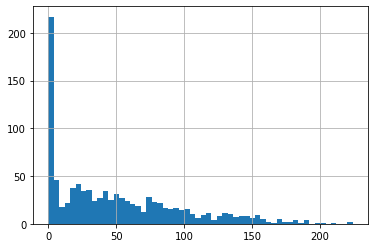

In [56]:
users_total_ultra['messages_number'].hist(bins = 56)

В очередной раз огромное количество нулевых значений. Удаляем их и анализируем данные повторно.

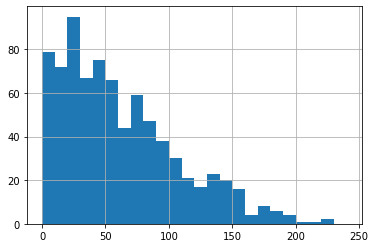

In [57]:
users_ultra_no_zero_mes = users_total_ultra[users_total_ultra['messages_number'] != 0]
users_ultra_no_zero_mes['messages_number'].hist(bins = 24, range = (0,240))

Поскольку среднее значение и стандартное отклонение практически равны, очевидно, что датафрейму требуется корректировка - обрезка "сверху". Сделаем это.

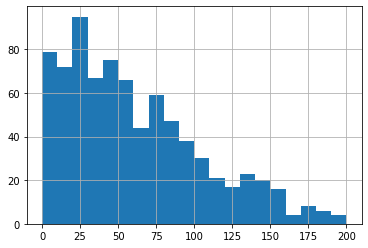

In [58]:
top_ultra_messages_limit = (users_ultra_no_zero_mes['messages_number'].mean() +
                      3 * users_ultra_no_zero_mes['messages_number'].std())
users_ultra_clean_mes = (users_ultra_no_zero_mes
                         [users_ultra_no_zero_mes['messages_number'] <= top_ultra_messages_limit])
users_ultra_clean_mes['messages_number'].hist(bins = 20, range = (0,200))

Построим совмещенную гистограмму и сравним значения, полученные для различных тарифов.

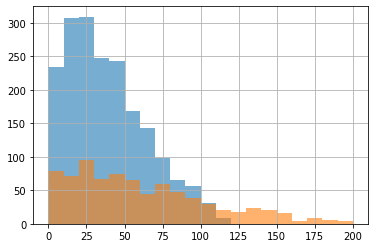

In [59]:
users_smart_clean_mes['messages_number'].hist(bins = 12, range = (0,120), alpha = 0.6)
users_ultra_clean_mes['messages_number'].hist(bins = 20, range = (0,200), alpha = 0.6)

По аналогии со звонками, разброс значений у пользователей тарифа ultra почти в 2 раза выше, чем у пользователей smart'а. Для понимания полной картины, выведем вместе статистические показатели и проанализируем их.

In [60]:
stats_val_comparison(users_smart_clean_mes, users_ultra_clean_mes, 'messages_number', "Количество сообщений")

Количество сообщений
                        smart  ultra
Среднее арифметическое     38     60
Медиана                    33     50
Стандартное отклонение     25     44
Дисперсия                 671   1999


Как и в случае со звонками, пользователи тарифа smart могут "переплачивать" за смс-сообщения, в отличие от пользователей ultra. Они, в свою очередь, также в 100% случае не выбирают "выданные" в начале месяца лимиты на бесплатные сообщения. Только теперь доля "полезной выработки" составляет не более 20% от общего объема. Логика та же, что и со звонками - предложить альтернативу. 

### Интернет-трафик

In [61]:
users_total_ultra['mb_used'].describe()

count      985.000000
mean     19486.901523
std      10096.317202
min          0.000000
25%      11785.000000
50%      19324.000000
75%      26863.000000
max      49789.000000
Name: mb_used, dtype: float64

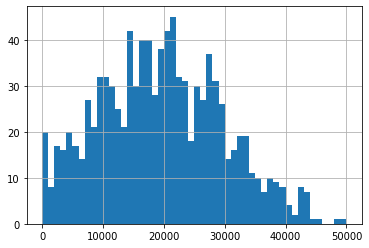

In [62]:
users_total_ultra['mb_used'].hist(bins = 50, range = (0, 50000))

Распределение также имеет форму нормального, однако, в связи с "частым" шагом построения гистограммы и относительно небольшим объемом анализируемых данных, имеет высокую "изрезанность" поверхности. Тем не менее, это не мешает нам продолжить расчистку и анализ данных.

In [63]:
users_ultra_no_zero_mb = (users_total_ultra
                          [users_total_ultra['mb_used'] != 0])

down_ultra_mb_limit = (users_ultra_no_zero_mb['mb_used'].mean() -
            3 * users_ultra_no_zero_mb['mb_used'].std())
top_ultra_mb_limit = (users_ultra_no_zero_mb['mb_used'].mean() + 
           3 * users_ultra_no_zero_mb['mb_used'].std())

print("Нижняя граница нормального распределения:", down_ultra_mb_limit)
print("Верхняя граница нормального распределения:", top_ultra_mb_limit)


Нижняя граница нормального распределения: -10104.402427294834
Верхняя граница нормального распределения: 49518.361359533024


Снизу снова 0, сверху значение очень близко к максимуму имеющихся данных.

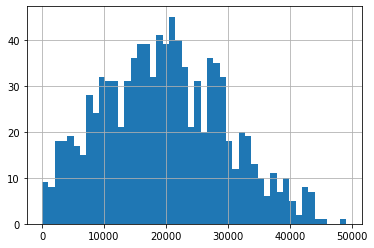

In [64]:
users_ultra_clean_mb = (users_ultra_no_zero_mb
                        [users_ultra_no_zero_mb['mb_used'] <= top_ultra_mb_limit])
users_ultra_clean_mb['mb_used'].hist(bins = 48, range = (0, 48*1024))

In [65]:
users_ultra_clean_mb['mb_used'].describe()

count      973.000000
mean     19676.062693
std       9895.258324
min        366.000000
25%      12062.000000
50%      19411.000000
75%      26889.000000
max      48395.000000
Name: mb_used, dtype: float64

Построим совместную диаграмму. Выведем на экран значения статистических параметров.

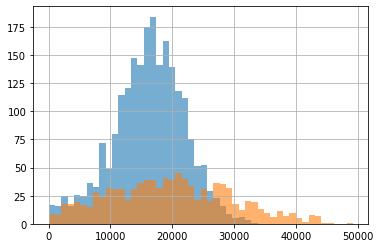

In [66]:
users_smart_clean_mb['mb_used'].hist(bins = 34, range = (0, 34*1024), alpha = 0.6)
users_ultra_clean_mb['mb_used'].hist(bins = 48, range = (0, 48*1024), alpha = 0.6)

In [67]:
stats_val_comparison(users_smart_clean_mb, users_ultra_clean_mb, 'mb_used', "Интернет-трафик")

Интернет-трафик
                           smart     ultra
Среднее арифметическое     16172     19676
Медиана                    16496     19411
Стандартное отклонение      5748      9895
Дисперсия               33045283  97916137


В среднем, пользователи тарифа ultra (несмотря на то, что их "меньшинство") используют в месяц больше интернет трафика, чем пользователи тарифа smart. Следует отметить, что если пользователи smart "в среднем" приобретают дополнительные пакеты интернета, то пользователи тарифа ultra "в среднем" этого не делают. За интернет в их случае "переплачивает" не более 20% от всех пользователей. Разница в стандартном отклонении почти в 2 раза (в пользу тарифа ultra) в очередной раз указывает нам на тот факт, что в ряде месяцев пользователи тарифа ultra расходуют лишь малую часть предоставленных им лимитов. С точки зрения личного финансового планирования, для них, вероятно, более выгодным было бы перейти на тариф smart. Однако, с точки зрения повышения выручки телекоммуникационной компании, безусловно такие клиенты - важное подспорье. Высокая выручка при минимальной (намного меньше планируемой - выставленной в качестве лимитов) себестоимости оказываемых услуг. Перейдем к проверке гипотез и выясним, какой из тарифных планов приносит большую выручку компании.

## 4. Формулирование и проверка гипотез

### Гипотеза №1
Первая гипотеза, которую необходимо проверить, звучит следующим образом: 

<font color='red'>средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.</font>

Сформулируем нулевую гипотезу следующим образом:

<font color='red'>H0 = "Средняя выручка компании по тарифу "Ультра" равна средней выручке по тарифу "Смарт"".</font>

Тогда альтернативная гипотеза будет иметь следующий вид:

<font color='red'>H1 = "Средняя выручка компании по тарифам "Ультра" и "Смарт" различается".</font>

Применяя метод ttest_ind, для сравнения двух генеральных совокупностей по взятым из них выборкам, я подумал по поводу необходимости использования параметра "equal_var". Принял решение передать ему значение False (не делать дисперсии г.совокупностей одинаковыми) в связи с существенным различием дисперсий исследованных ранее выборок для различных тарифов.

In [68]:
rev_sm_ult_result = st.ttest_ind(users_total_smart['total_revenue'], 
                                 users_total_ultra['total_revenue'], 
                                 equal_var = False)
rev_sm_ult_result.pvalue

2.7240946993530846e-246

Вероятность случайного возникновения различия между выборками невероятно мала (в -246 степени). И вне зависимости от того, какой критический уровень стат.значимости мы примем (5%, 1%, 0.01%), в любом случае, он будет больше полученного значения. Потому я отвергаю нулевую гипотезу. Соответственно, выдвинутая ранее в рамках реализации проекта гипотеза <font color='red'>"средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"</font> (соответствующая альтернативной гипотезе H1) имеет право на существование.

### Гипотеза №2
Вторая гипотеза звучит следующим образом: 

<font color='red'>средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.</font>

Сформулируем нулевую гипотезу следующим образом:

<font color='red'>H0 = "Средняя выручка компании от пользователей из Москвы равна средней выручке от пользователей из других регионов".</font>

Тогда альтернативная гипотеза будет иметь следующий вид:

<font color='red'>H1 = "Средняя выручка компании от пользователей из Москвы отличается от средней выручки от пользователей из других регионов".</font>

В первую очередь, нам необходимо "собрать" необходимые для анализа выборки. Если при проверке предшествующей гипотезы мы пользовались сгруппированными ранее выборками, то сейчас нам необходимо их "разделить" по критерию города и "склеить" в обратную сторону по этому же критерию (Смарт-Москва + Ультра-Москва и Смарт-Остальные + Ультра-Остальные).

Начнем c добавления столбца "город" в имеющиеся датасеты.

In [69]:
id_all = users['city']
id_all.index = users['user_id']

users_total_smart_city = users_total_smart.merge(id_all, how = 'left', on = 'user_id')
users_total_smart_city.head(10)

,calls_duration,calls_number,mb_used,messages_number,min_excess,mb_excess,mes_excess,min_exc_rev,mb_exc_rev,mes_exc_rev,total_revenue,city
user_id,,,,,,,,,,,,
1001,430,45,18452,0,0,3092,0,0,800,0,1350,Москва
1001,414,47,14053,0,0,0,0,0,0,0,550,Москва
1002,117,14,10871,4,0,0,0,0,0,0,550,Стерлитамак
1002,214,21,17601,11,0,2241,0,0,600,0,1150,Стерлитамак
1002,289,37,20347,13,0,4987,0,0,1000,0,1550,Стерлитамак
1002,206,25,16712,4,0,1352,0,0,400,0,950,Стерлитамак
1002,212,24,13905,10,0,0,0,0,0,0,550,Стерлитамак
1002,243,25,18610,16,0,3250,0,0,800,0,1350,Стерлитамак
1002,236,27,18137,12,0,2777,0,0,600,0,1150,Стерлитамак


В процессе добавления столбца "город" я "потерял" часть мультииндекса - "месяц", однако, для решения нашей задачи он нам не нужен. Продолжаем операции с датасетами.

In [70]:
users_total_ultra_city = users_total_ultra.merge(id_all, how = 'left', on = 'user_id')
users_total_ultra_city.head(10)

,calls_duration,calls_number,mb_used,messages_number,min_excess,mb_excess,mes_excess,min_exc_rev,mb_exc_rev,mes_exc_rev,total_revenue,city
user_id,,,,,,,,,,,,
1000,159,17,2256,22,0,0,0,0,0,0,1950,Краснодар
1000,172,28,23257,60,0,0,0,0,0,0,1950,Краснодар
1000,340,41,14016,75,0,0,0,0,0,0,1950,Краснодар
1000,408,42,14070,81,0,0,0,0,0,0,1950,Краснодар
1000,466,46,14581,57,0,0,0,0,0,0,1950,Краснодар
1000,350,44,14717,73,0,0,0,0,0,0,1950,Краснодар
1000,338,37,14768,58,0,0,0,0,0,0,1950,Краснодар
1000,333,38,9827,70,0,0,0,0,0,0,1950,Краснодар
1003,380,43,8571,37,0,0,0,0,0,0,1950,Москва


Делаем выборки по городу и склеиваем полученное.

In [71]:
users_total_smart_moscow = users_total_smart_city[users_total_smart_city
                                                  ['city'] == "Москва"]
users_total_ultra_moscow = users_total_ultra_city[users_total_ultra_city
                                                  ['city'] == "Москва"]

users_total_moscow = pd.concat([users_total_smart_moscow, users_total_ultra_moscow], 
                               keys = ['smart', 'ultra'])

users_total_moscow

calls_duration  calls_number  mb_used  messages_number  \
      user_id                                                           
smart 1001                430            45    18452                0   
      1001                414            47    14053                0   
      1007                198            21     8031               11   
      1007                480            57    17708               39   
      1007                545            55    13674               26   
...                       ...           ...      ...              ...   
ultra 1476                622            59    18620                5   
      1476                540            60    25148                4   
      1476                556            59    14423                6   
      1476                588            67    14136               11   
      1476                  0             0      531                0   

               min_excess  mb_excess  mes_excess  min_exc_rev  mb_exc_rev  \
      user_id                                                               
smart 1001              0       3092           0            0         800   
      1001              0          0           0            0           0   
      1007              0          0           0            0           0   
      1007              0       2348           0            0         600   
      1007             45          0           0          135           0   
...                   ...        ...         ...          ...         ...   
ultra 1476              0          0           0            0           0   
      1476              0          0           0            0           0   
      1476              0          0           0            0           0   
      1476              0          0           0            0           0   
      1476              0          0           0            0           0   

               mes_exc_rev  total_revenue    city  
      user_id                                      
smart 1001               0           1350  Москва  
      1001               0            550  Москва  
      1007               0            550  Москва  
      1007               0           1150  Москва  
      1007               0            685  Москва  
...                    ...            ...     ...  
ultra 1476               0           1950  Москва  
      1476               0           1950  Москва  
      1476               0           1950  Москва  
      1476               0           1950  Москва  
      1476               0           1950  Москва  

[611 rows x 12 columns]

In [72]:
users_total_smart_other = users_total_smart_city[users_total_smart_city
                                                  ['city'] != "Москва"]
users_total_ultra_other = users_total_ultra_city[users_total_ultra_city
                                                  ['city'] != "Москва"]

users_total_other = pd.concat([users_total_smart_other, users_total_ultra_other], 
                               keys = ['smart', 'ultra'])
users_total_other

calls_duration  calls_number  mb_used  messages_number  \
      user_id                                                           
smart 1002                117            14    10871                4   
      1002                214            21    17601               11   
      1002                289            37    20347               13   
      1002                206            25    16712                4   
      1002                212            24    13905               10   
...                       ...           ...      ...              ...   
ultra 1473                  0             0    12917               17   
      1473                  0             0    17307               19   
      1473                  0             0    13703               20   
      1473                  0             0    21692               14   
      1473                  0             0    18432               20   

               min_excess  mb_excess  mes_excess  min_exc_rev  mb_exc_rev  \
      user_id                                                               
smart 1002              0          0           0            0           0   
      1002              0       2241           0            0         600   
      1002              0       4987           0            0        1000   
      1002              0       1352           0            0         400   
      1002              0          0           0            0           0   
...                   ...        ...         ...          ...         ...   
ultra 1473              0          0           0            0           0   
      1473              0          0           0            0           0   
      1473              0          0           0            0           0   
      1473              0          0           0            0           0   
      1473              0          0           0            0           0   

               mes_exc_rev  total_revenue         city  
      user_id                                           
smart 1002               0            550  Стерлитамак  
      1002               0           1150  Стерлитамак  
      1002               0           1550  Стерлитамак  
      1002               0            950  Стерлитамак  
      1002               0            550  Стерлитамак  
...                    ...            ...          ...  
ultra 1473               0           1950   Красноярск  
      1473               0           1950   Красноярск  
      1473               0           1950   Красноярск  
      1473               0           1950   Красноярск  
      1473               0           1950   Красноярск  

[2603 rows x 12 columns]

Строк в обоих датасетах суммарно 2603 + 611 = 3214 - как и было ранее, здесь ошибок не наблюдается. Теперь на основании полученных датасетов мы можем проверить нашу гипотезу:

<font color='red'>H0 = "Средняя выручка компании от пользователей из Москвы равна средней выручке от пользователей из других регионов".</font>

In [73]:
rev_msc_oth_result = st.ttest_ind(users_total_moscow['total_revenue'], 
                                 users_total_other['total_revenue'], 
                                 equal_var = False)
rev_msc_oth_result.pvalue

0.5126564657748214

Вывод также не зависит от выбора значения критерия. По итогу - мы не можем отклонить нулевую гипотезу, т.к. вероятность "случайности" слишком высока - более 50%. Соответственно, изначальная гипотеза (которую необходимо было проверить по заданию - <font color='red'>средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов</font>) опровергнута. 

## Дополнительные вычисления

Несмотря на существенный объем проведенных исследований, мы до сих пор не ответили на главный вопрос - "Какой тариф приносит больше денег"?

Для этого проведем односторонний тест где в качестве "базового" датасета будет выступать выборка пользователей тарифа "Смарт", "интересующего значения" - средняя выручка от пользователей тарифа "Ультра", а критический уровень составит 1%. Думаю, что такой точности будет достаточно, для того, чтобы оценить расхождения между исследуемыми выборками.

В таком случае, нашей нулевой гипотезой будет:

<font color='red'>H0 = средняя выручка по тарифу "Смарт" больше или равна выручке по тарифу "Ультра"</font>

Альтернативная гипотеза:

<font color='red'>H1 = средняя выручка по тарифу "Смарт" меньше выручки по тарифу "Ультра"</font>

In [74]:
interested_value = users_total_ultra['total_revenue'].mean()

smart_ultra_revenue_result = st.ttest_1samp(users_total_smart['total_revenue'], interested_value)

print("p-значение:", smart_ultra_revenue_result.pvalue / 2)
print('Средняя выручка по тарифу "Смарт":', users_total_smart['total_revenue'].mean())
print('Средняя выручка по тарифу "Ультра":', interested_value)

p-значение: 7.16947855739e-312
Средняя выручка по тарифу "Смарт": 1294.6393001345896
Средняя выручка по тарифу "Ультра": 2071.0659898477156


Полученное значение p_value несоизмеримо меньше выбранного критического уровня. Плюс ко всему, среднее значение выручки по тарифу "Смарт" меньше среднего по тарифу "Ультра". Соответственно гипотеза H0 не подтверждена. И больше выручки, статистически приносит тариф "Ультра".

## 5. Общие выводы

Задача, поставленная департаментом была сформулирована следующим образом: "Какой тариф приносит больше денег"?

1. Тариф "Ультра" действительно приносит больше денежных средств из расчета человек на человека (1 к 1). Т.е. если сравнивать двух гипотетических (сферических в вакууме) пользователей данных тарифов, то пользователь "Ультра" статистически приносит БОЛЬШЕ денег компании. 


2. Тем не менее, данный вывод требует некоторых корректирующих дополнений. Несмотря на пункт 1 и судя по имеющейся выборке, пользователей тарифа "Ультра" меньше, чем пользователей тарифа "Смарт" примерно в 4 раза (именно пользователей, а не данных по месяцам, которые мы анализировали). Соответственно, за счёт численного превосходства, пользователи "Смарта" могут приносить компании большую прибыль, нежели пользователи "Ультра" (как в сети магазинов "Fix Price" и им подобных - огромное число продаж * на минимальную маржинальность может также приносить существенные дивиденды". Для уточнения данного момента необходимо знание о себестоимости привлечения клиента на каждый из тарифов, сопровождения, обслуживания и пр. затрат, дабы иметь возможность рассчитать среднюю маржинальность пользователей каждого из тарифов. Без этой информации дать максимально корректный ответ на исходный вопрос проблематично.


3. Возвращаясь к вопросу о себестоимости услуг, предоставляемых пользователям - в случае тарифа "Смарт", пользователи зачастую ПОЛНОСТЬЮ расходуют лимиты по звонкам (в 30+% случаев), по сообщениям (в 30+% случаев), по интернет-трафику (в 50+% случаев). В случае же пользователей тарифа "Ультра" такая ситуация применима только в случае интернет-трафика, причем доля "перерасходов" там куда ниже (порядка 20%). Соответственно с точки зрения "запланированной себестоимости клиента" тариф "Ультра" является более выгодным - при фиксированной плате в 1950 рублей, они не "выговаривают" и трети от предложенных 3000 минут и не отправляют более 200 смс (при лимите в 1000). Т.е. пользователи "Ультра" ежемесячно "сливают" в пустоту существенное количество денежных средств.


4. Добавляя в эту историю значения средней выручки, можно увидеть основной источник формирования прибыли в зависимости от тарифа. В случае тарифа "Смарт" - это использование опций СВЕРХ тарифных лимитов - минут, смс, гигабайтов трафика. При абонентской плате в 550 рублей, среднее значение выручки на такого клиента - 1294 рубля. Тратить на доп. услуги в среднем 750 рублей (в 1.5 раза больше абонентской платы!) - безумие. Почему клиенты до сих пор его длят - не совсем понятно. В случае же тарифа "Ультра" ситуация противоположная - там основной источник выручки это абонентская плата (АП). При АП = 1950 рублей в месяц, средняя выручка на клиента составляет 2071 рубль. Следовательно, пользователи данного тарифа "не привыкли" тратить деньги сверх АП.


5. На мой взгляд, возможным путем дальнейшего движения компании может стать создание нового "промежуточного" тарифа, который будет включать в себя больше минут, смс и гигабайт, и стоить порядка 1000-1300 рублей в месяц. Это позволит сохранить в числе клиентов пользователей, НЕДОВОЛЬНЫХ имеющейся тарифной сеткой (550 и 1950 - где промежуток, где индивидуальность?!), а также повысить долю доходов от абонентской платы. Дальнейшее исследование требует большего объема данных и общения с другими отделами :) 